In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd '/content/drive/MyDrive/Dicoding/ML Pengembangan'

/content/drive/MyDrive/Dicoding/ML Pengembangan


In [57]:
import numpy as np
import pandas as pd

from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [58]:
df = pd.read_csv('AAPL.csv')
print(df)

            Date        Open        High         Low       Close   Adj Close  \
0     1990-06-25    0.370536    0.372768    0.359375    0.368304    0.294235   
1     1990-06-26    0.372768    0.375000    0.360491    0.362723    0.289777   
2     1990-06-27    0.363839    0.375000    0.359375    0.370536    0.296018   
3     1990-06-28    0.381696    0.386161    0.372768    0.383929    0.306718   
4     1990-06-29    0.383929    0.400670    0.381696    0.399554    0.319201   
...          ...         ...         ...         ...         ...         ...   
8308  2023-06-16  186.729996  186.990005  184.270004  184.919998  184.919998   
8309  2023-06-20  184.410004  186.100006  184.410004  185.009995  185.009995   
8310  2023-06-21  184.899994  185.410004  182.589996  183.960007  183.960007   
8311  2023-06-22  183.740005  187.050003  183.669998  187.000000  187.000000   
8312  2023-06-23  185.550003  187.559998  185.009995  186.679993  186.679993   

         Volume  
0     122001600  
1  

In [59]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [60]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

print(rows_with_NaN)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [61]:
print((df.Open[164]+df.Open[166])/2)

0.5212055


In [62]:
# Mengganti nilai NaN di kolom Open baris 165 dengan rata-rata yang didapatkan
df = df.fillna(value = {'Open': 0.11160700000000001})

#Mengecek apakah nilai sudah terganti
df.Open[165]

0.513393

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8313 non-null   object 
 1   Open       8313 non-null   float64
 2   High       8313 non-null   float64
 3   Low        8313 non-null   float64
 4   Close      8313 non-null   float64
 5   Adj Close  8313 non-null   float64
 6   Volume     8313 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 454.7+ KB


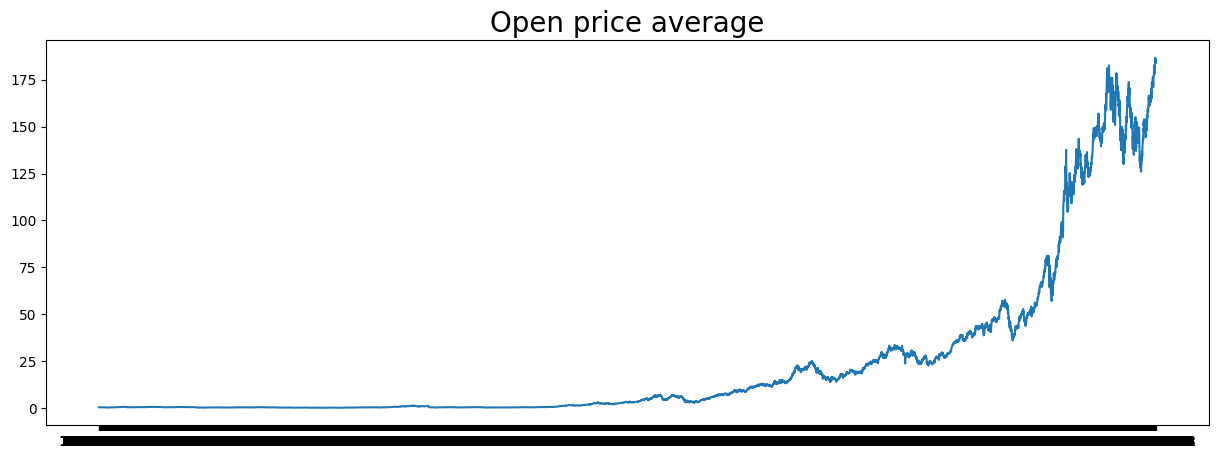

In [64]:
# Plot data
dates = df['Date'].values
price = df['Open'].values

plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('Open price average', fontsize=20);


In [65]:
# Membagi data menjadi training set dan validation set
from sklearn.model_selection import train_test_split
date_train, date_valid, price_train, price_valid = train_test_split(dates, price, train_size=0.8, test_size = 0.2, shuffle = False )


# Mengubah format data
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import regularizers

train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(price_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_8 (LSTM)               (None, None, 64)          24832     
                                                                 
 lstm_9 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense_5 (Dense)             (None, None, 30)          1950      
                                                                 
 dense_6 (Dense)             (None, None, 10)          310       
                                                                 
 dense_7 (Dense)             (None, None, 1)           11        
                                                                 
 lambda_1 (Lambda)           (None, None, 1)          

In [67]:
# Menghitung MAE
MAE = 0.1*(max(df.Open)-min(df.Open))
print(MAE)

18.6615041


In [68]:
# Menerapkan callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<MAE):
      print("\nMAE sudah dibawah ", MAE , ", train data diberhentikan.")
      self.model.stop_training = True

callbacks = myCallback()

In [69]:
history = model.fit(train_set, epochs=100, callbacks=[callbacks])

Epoch 1/100
     66/Unknown - 22s 239ms/step - loss: 8.7490 - mae: 9.2445
MAE sudah dibawah  18.6615041 , train data diberhentikan.
66/66 [==============================] - 22s 240ms/step - loss: 8.7490 - mae: 9.2445
